In [ ]:
import wellmap
import pandas as pd
import os
import string
import seaborn as sns
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt

New for multiple images in CP file

In [ ]:
part_to_folder = r"C:\Users\Modern\Documents\Biorad\CellProfiler\Results\2024-08-08 RZ hTERT DMSO"

# files = [f for f in listdir(part_to_folder) if isfile(join(part_to_folder, f))]

image_list_path = os.path.join(part_to_folder, "ExpImage.csv")
data_path  = os.path.join(part_to_folder, "ExpWells_plate.csv")

data_raw_df = pd.read_csv(data_path) 
image_list_df = pd.read_csv(image_list_path) 

print(image_list_df)


Extract wellmaps and combine into one df with names of the images

In [ ]:
wellmap_path_list = []

for file in os.listdir(part_to_folder):
    if file.endswith(".toml"):
        wellmap_path_list.append(os.path.join(part_to_folder, file))
        # wellmap_path_list.append(file)

print(wellmap_path_list[0])

wellmap_df = wellmap.load(wellmap_path_list[0]) 

wellmap_list = []

for file in wellmap_path_list:
    wellmap_i = wellmap.load(file)
    wellmap_list.append(wellmap_i)

wellmaps_df = pd.concat(wellmap_list, axis=0, ignore_index=True)
# print(wellmaps_df)

wellmap.show(file);
plt.show();

Generating labels for wells

In [ ]:
# row_column_df = pd.DataFrame(columns=['row','col'])

row =  list(string.ascii_uppercase[0:8])
column = list(range(1,13))
plate = image_list_df['FileName_RGB'].to_list()

row_column_list = []


for p in plate:
    for c in column:
        for r in row:
            array_i = [r,c]
            row_column_list.append(array_i)

row_column_df = pd.DataFrame(row_column_list, columns = ['row', 'col']) 

print(row_column_df)

Add images names to data (thank you CellProfiler for convenience)

Percents

In [ ]:
data_full_df =  pd.merge(data_raw_df, image_list_df, on='ImageNumber') #Data with image names (FileName_RGB)
data_indexed = pd.concat([row_column_df, data_full_df], axis=1, join='inner') #Data with image names (FileName_RGB) and cell indexes (row,col)

data_indexed['col']=data_indexed['col'].astype(str) #Otherwise everything will break

data_plate = pd.merge(data_indexed, wellmaps_df, on=['FileName_RGB','row','col']) #Data with image names (FileName_RGB), cell indexes and wellmap
data_plate[["conc_pc"]] = data_plate[["conc_pc"]].apply(pd.to_numeric)

print(data_plate.columns)


Micromoles

In [ ]:
data_full_df =  pd.merge(data_raw_df, image_list_df, on='ImageNumber') #Data with image names (FileName_RGB)
data_indexed = pd.concat([row_column_df, data_full_df], axis=1, join='inner') #Data with image names (FileName_RGB) and cell indexes (row,col)

data_indexed['col']=data_indexed['col'].astype(str) #Otherwise everything will break

data_plate = pd.merge(data_indexed, wellmaps_df, on=['FileName_RGB','row','col']) #Data with image names (FileName_RGB), cell indexes and wellmap
data_plate[["conc_uM"]] = data_plate[["conc_uM"]].apply(pd.to_numeric)

print(data_plate.columns)
print(data_plate['sample'].unique())

In [ ]:
cul_type_list = data_plate['culture_type'].unique()

data_plate_corrected = data_plate.iloc[:0,:].copy()  #Clone of plates df but empty

print(cul_type_list)

for c_type in cul_type_list:
    data_plate_i = data_plate[(data_plate['culture_type'] == c_type)]
    reference_plate = data_plate_i[(data_plate_i['RZ_incubation'] == '0H')]
    sample_plate = data_plate_i[(data_plate_i['RZ_incubation'] != '0H')]

    reference_plate = reference_plate.reset_index(drop=True)
    sample_plate = sample_plate.reset_index(drop=True)

    mean = reference_plate['Intensity_IntegratedIntensity_OrigGreen'].mean()
    
    reference_plate['Mean_dif'] = reference_plate['Intensity_MeanIntensity_OrigGreen']/mean

    sample_plate['Mean_corr'] = sample_plate['Intensity_MeanIntensity_OrigGreen']/reference_plate['Mean_dif'] 


    data_plate_corrected = data_plate_corrected.append(sample_plate)



In [ ]:
sample_list = data_plate['sample'].unique()

data_plate_corrected = data_plate.iloc[:0,:].copy()  #Clone of plates df but empty

print(sample_list)

for sample in sample_list:
    data_plate_i = data_plate[(data_plate['sample'] == sample)]
    reference_plate = data_plate_i[(data_plate_i['RZ_incubation'] == '0H')]
    sample_plate = data_plate_i[(data_plate_i['RZ_incubation'] != '0H')]

    reference_plate = reference_plate.reset_index(drop=True)
    sample_plate = sample_plate.reset_index(drop=True)

    mean = reference_plate['Intensity_IntegratedIntensity_OrigGreen'].mean()
    
    reference_plate['Mean_dif'] = reference_plate['Intensity_MeanIntensity_OrigGreen']/mean

    sample_plate['Mean_corr'] = sample_plate['Intensity_MeanIntensity_OrigGreen']/reference_plate['Mean_dif'] 


    data_plate_corrected = data_plate_corrected.append(sample_plate)



In [ ]:
ay = sns.swarmplot(data=data_plate_corrected, x="conc_uM", y="Mean_corr", hue = 'sample')

In [ ]:
ay = sns.swarmplot(data=data_plate_corrected, x="conc_pc", y="Mean_corr", hue = 'culture_type')

In [ ]:
blank_array = []

plate_list = data_plate_corrected['FileName_RGB'].unique()
print(plate_list)

for p in plate_list:
    blank_p = data_plate_corrected[(data_plate_corrected['blank'] == 'Yes') & 
                                   (data_plate_corrected['FileName_RGB'] == p)].loc[:,'Mean_corr'].mean()
    
    blank_std_p = data_plate_corrected[(data_plate_corrected['blank'] == 'Yes') 
                                       & (data_plate_corrected['FileName_RGB'] == p)].loc[:,'Mean_corr'].std()

    bc_array_i = [blank_p, blank_std_p ,p]

    print(bc_array_i)

    blank_array.append(bc_array_i)

    blank_df = pd.DataFrame(blank_array, columns = ['blank_mean','blank_std','FileName_RGB']) 

data_plate_with_blank_values = pd.merge(data_plate_corrected, blank_df, on=['FileName_RGB'])



In [ ]:
data_plate_with_blank_values['Green_blanked'] = data_plate_with_blank_values['Mean_corr'] - data_plate_with_blank_values['blank_mean']

data_plate_wo_blank = data_plate_with_blank_values[data_plate_with_blank_values.blank == 'No'].copy() #dataframe without blank

control_array = []

for p in plate_list:
    control_p = data_plate_wo_blank[(data_plate_wo_blank['control'] == 'Yes') & 
                                    (data_plate_wo_blank['FileName_RGB'] == p)].loc[:,'Green_blanked'].mean()

    control_std_p = data_plate_wo_blank[(data_plate_wo_blank['control'] == 'Yes') & 
                                        (data_plate_wo_blank['FileName_RGB'] == p)].loc[:,'Green_blanked'].std()
    

    ctr_array_i = [control_p, control_std_p ,p]


    control_array.append(ctr_array_i)

    control_df = pd.DataFrame(control_array, columns = ['control_mean','control_std','FileName_RGB']) 

print(control_df)

data_plate_with_control = pd.merge(data_plate_wo_blank, control_df, on=['FileName_RGB'])


In [ ]:
data_plate_with_control['Green_relative'] = data_plate_with_control['Green_blanked']/data_plate_with_control['control_mean']*100

ax = sns.relplot(data=data_plate_with_control, x="conc_uM", y="Green_relative", hue = 'sample',  kind="line")

ax.set(xscale="symlog")

ax.set(xlim=(0, 10),ylim = (0,120))

ax.set(xlabel='Concentration, uM', ylabel='Cell viability relative to control, %')

plt.show()


In [ ]:
data_plate_with_control['Green_relative'] = data_plate_with_control['Green_blanked']/data_plate_with_control['control_mean']*100

ax = sns.relplot(data=data_plate_with_control, x="conc_pc", y="Green_relative", hue = 'culture_type',  kind="line")

# ax.set(xscale="symlog")

# ax.set(xlim=(0, 10),ylim = (0,120))

ax.set(xlabel='Concentration, pc', ylabel='Cell viability relative to control, %')

plt.show()

In [ ]:
ax = sns.boxplot(data=data_plate_with_control, x="conc_uM", y="Green_relative", hue = 'sample')


ax.set(xlim=(-1, None),ylim = (0,130))

[(-1.0, 5.5), (0.0, 130.0)]

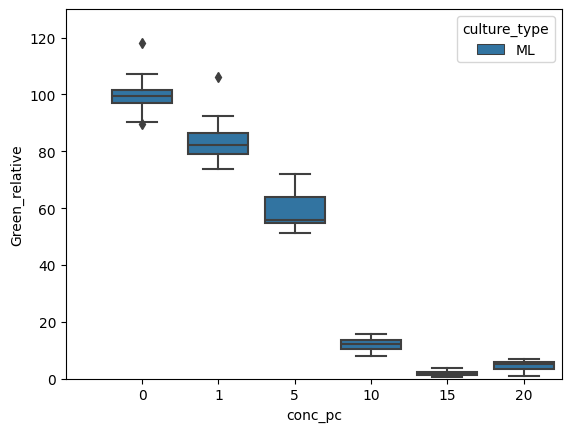

In [40]:
ax = sns.boxplot(data=data_plate_with_control, x="conc_pc", y="Green_relative", hue = 'culture_type')


ax.set(xlim=(-1, None),ylim = (0,130))

In [42]:
file_name = part_to_folder + '/data_processed.csv'

data_plate_with_control.to_csv(file_name)